# Reproduction Number

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mdates
from datetime import datetime
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings('ignore')
from platform import python_version
print("python version: %s"%python_version())
print("numpy version: %s"%np.__version__)
print("pandas version: %s"%pd.__version__)
print("matplotlib version: %s"%mpl.__version__)

python version: 3.8.2
numpy version: 1.18.1
pandas version: 1.0.2
matplotlib version: 3.3.1


In [2]:
#url_confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
url_confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
confirmed_dataset = pd.read_csv(url_confirmed) 
# creates an index of dates
start_date_index = 43 # starts from March 1st
end_date_index = len(confirmed_dataset.columns) 
start_day = pd.to_datetime(confirmed_dataset.columns[start_date_index]).strftime('%Y-%m-%d')
end_day = pd.to_datetime(confirmed_dataset.columns[end_date_index - 1]).strftime('%Y-%m-%d')
date_index = pd.date_range(start_day, end_day)
week_index = pd.date_range(start_day, end_day, freq='W')
date_index_array = [date.strftime('%Y-%m-%d') for date in date_index] # dates array used for plotting

In [3]:
confirmed_dataset_it = confirmed_dataset[confirmed_dataset['Country/Region'] == 'Italy']
confirmed_dataset_values_it = [confirmed for confirmed in confirmed_dataset_it.values[0][start_date_index:]] 
confirmed_infections_it = pd.Series(confirmed_dataset_values_it, index=date_index)
confirmed_infections_it['2020-11-01':]

2020-11-01    709335
2020-11-02    731588
Freq: D, dtype: int64

In [4]:
confirmed_per_day_array_it = [confirmed_infections_it[d++1] - confirmed_infections_it[d] for d in range(date_index.size - 1)]
confirmed_per_day_it = pd.Series(confirmed_per_day_array_it, index=date_index[1:])
confirmed_per_day_it['2020-11-01':]

2020-11-01    29905
2020-11-02    22253
Freq: D, dtype: int64

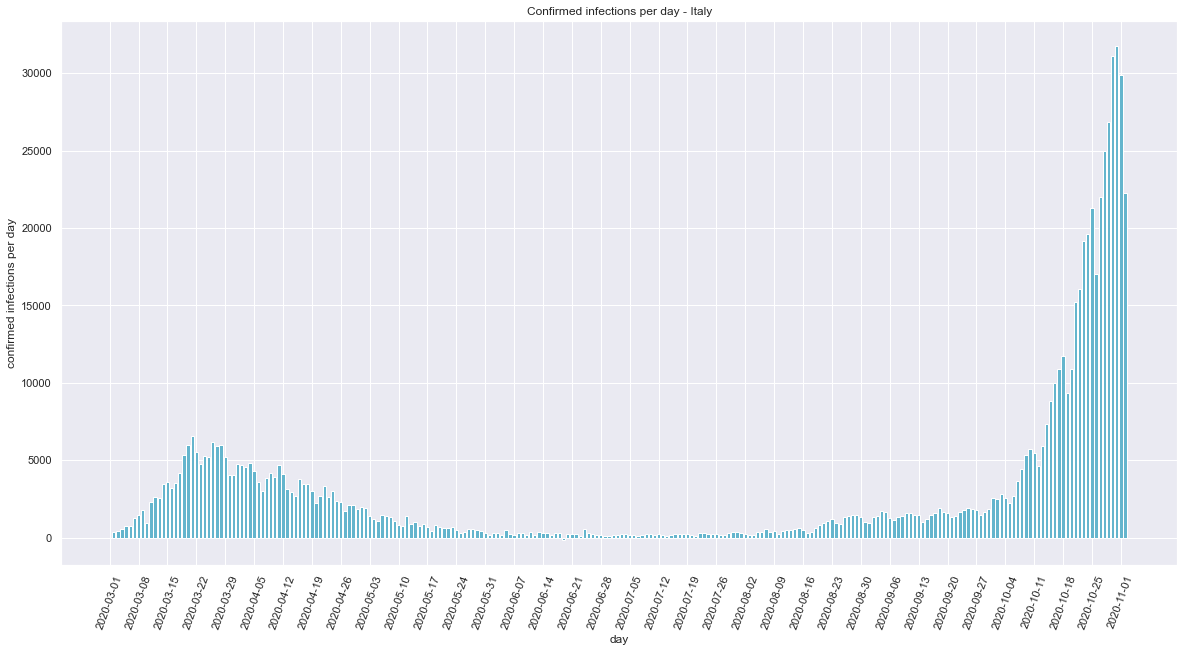

In [5]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Confirmed infections per day - Italy")
ax.set_xlabel("day")
ax.set_ylabel("confirmed infections per day");
ax.set_xticks(week_index)
ax.set_xticklabels(week_index, rotation=70)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.bar(date_index_array[1:], confirmed_per_day_array_it, color='c')
plt.savefig('confirmed-infections-italy.png')

In [6]:
import math
log_confirmed = [math.log(confirmed) for confirmed in confirmed_per_day_array_it[145:]]
len(log_confirmed)

101

In [7]:
import numpy as np
from scipy.optimize import curve_fit

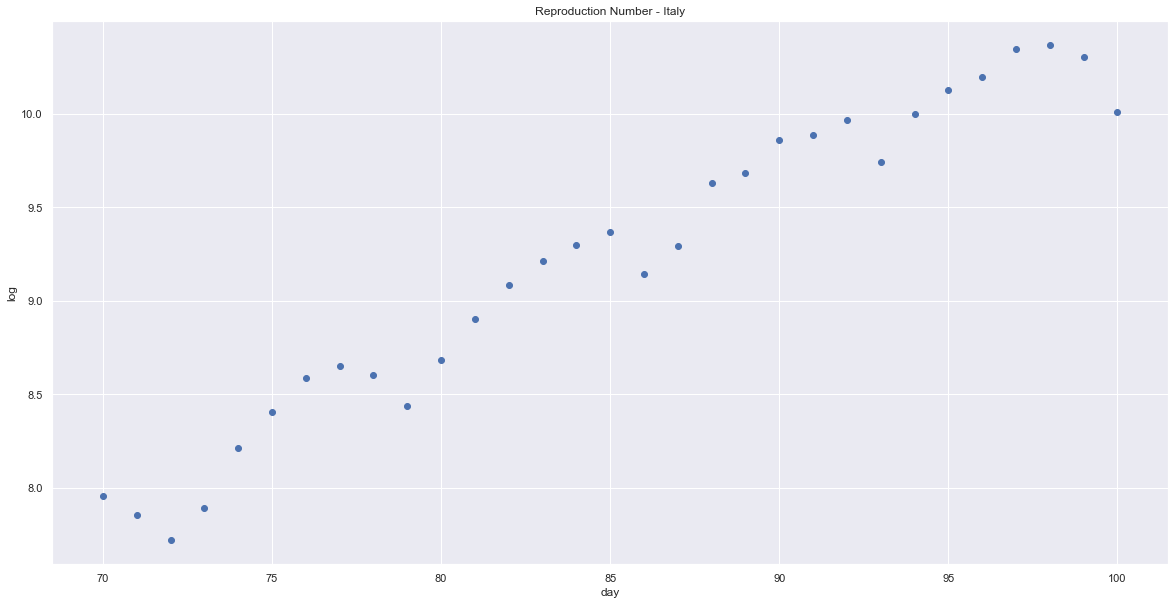

In [13]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Reproduction Number - Italy")
ax.set_xlabel("day")
ax.set_ylabel("log");
x = np.arange(70,101,1)
y = log_confirmed[70:101]
plt.plot(x, y, 'o')

In [14]:
def linearfunc(x, a, b):
    return a * x + b 

In [27]:
popt, pcov = curve_fit(linearfunc, x, y) # estimates the parameters of the linear function a, b
a = popt[0]
b = popt[1]
print(a, b)
perr = np.sqrt(np.diag(pcov))
error_a = perr[0]
error_b = perr[1]
print(error_a, error_b)

0.08804450656894158 1.7229898904480137
0.003579815869324556 0.3059643316934743


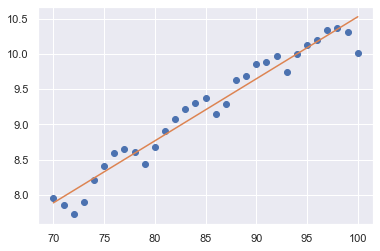

In [16]:
yfit = linearfunc(x, a, b)
plt.plot(x, y, 'o')
plt.plot(x,yfit)